# Convolutional classifier

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

## Data

Load a custom subclass of torchvision.datasets.MNIST that instead downloads the FashionMNIST dataset 

(waiting for [this commit](https://github.com/pytorch/vision/commit/eec5ba4405c8815bd1797619d9cc9276f81b76f4) be available in the pip version of PyTorch).

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))
from data.fashion import FashionMNIST
from models.flatten import Flatten

Load train and test set in batches of 1000

In [3]:
batch_size = 1000

train_dataset = FashionMNIST('../data', train=True, download=True, 
                             transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST('../data', train=False, download=True, 
                            transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model

The model first applies a __batch norm__ layer, followed by 2 __convolution-maxpool-relu__ layers and finally a __fully connected__ layer on the flattened output of the last convolution

In [4]:
model = nn.Sequential(
    nn.BatchNorm2d(1, affine=False),
    nn.Conv2d(1, 10, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(10, 20, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Dropout2d(p=0.2),
    Flatten(),
    nn.Linear(320, FashionMNIST.num_classes),
    nn.LogSoftmax()
)

## Training

Note: because of batch normalization, now it's important to specify `model.train()` and `model.eval()`.

In [5]:
model.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
epoch_loss = []

for epoch in range(20):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data[0])
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

Epoch 0:	loss 1.2313	accuracy 73.70%
Epoch 1:	loss 0.6370	accuracy 79.40%
Epoch 2:	loss 0.5347	accuracy 82.00%
Epoch 3:	loss 0.4860	accuracy 84.40%
Epoch 4:	loss 0.4592	accuracy 86.10%
Epoch 5:	loss 0.4334	accuracy 87.30%
Epoch 6:	loss 0.4199	accuracy 83.80%
Epoch 7:	loss 0.4053	accuracy 85.10%
Epoch 8:	loss 0.3921	accuracy 85.10%
Epoch 9:	loss 0.3832	accuracy 88.60%
Epoch 10:	loss 0.3727	accuracy 87.90%
Epoch 11:	loss 0.3671	accuracy 86.40%
Epoch 12:	loss 0.3585	accuracy 87.20%
Epoch 13:	loss 0.3528	accuracy 88.00%
Epoch 14:	loss 0.3445	accuracy 86.30%
Epoch 15:	loss 0.3422	accuracy 88.30%
Epoch 16:	loss 0.3388	accuracy 87.90%
Epoch 17:	loss 0.3323	accuracy 88.70%
Epoch 18:	loss 0.3297	accuracy 87.70%
Epoch 19:	loss 0.3271	accuracy 86.90%


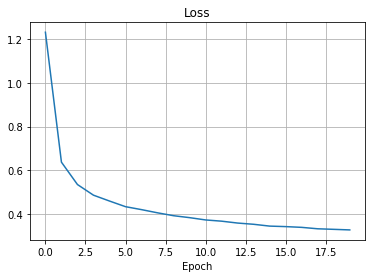

In [6]:
plt.plot(epoch_loss)
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid(True)

## Evaluation

Evaluation on a single batch

In [7]:
model.eval()

data, targets = next(test_loader.__iter__())
outputs = model(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 89.10%


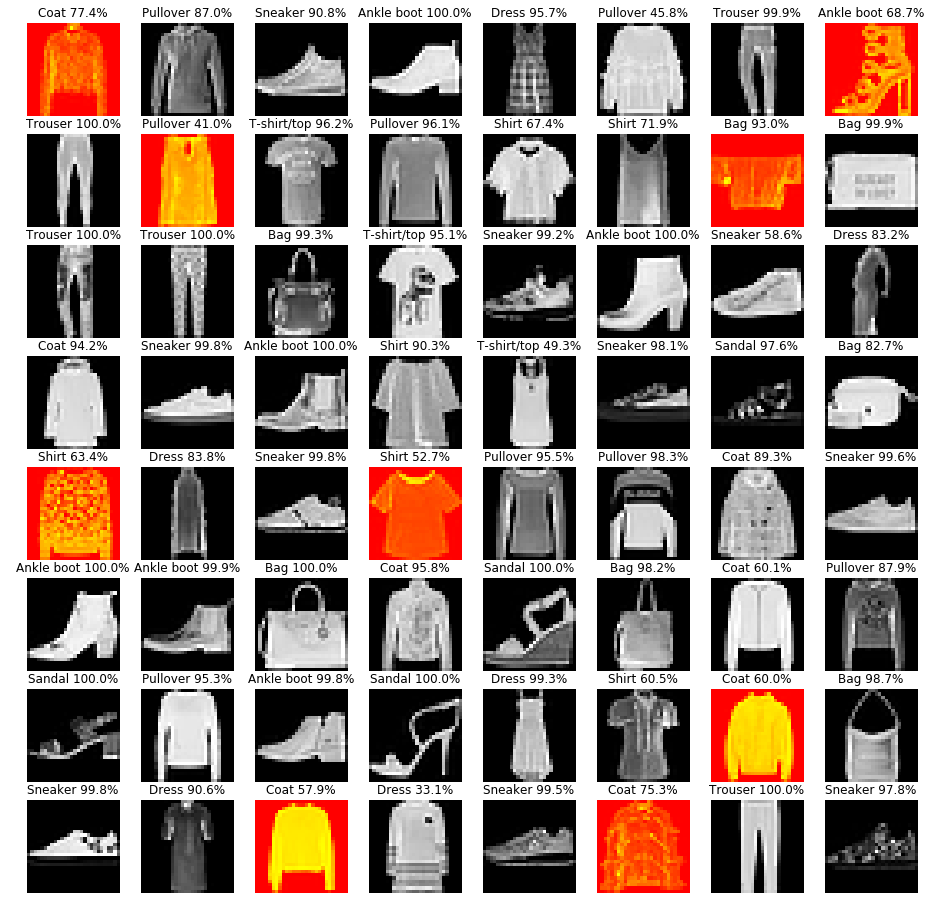

In [8]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axes.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img.reshape(FashionMNIST.input_shape), cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FashionMNIST.labels[output_class], prob))

## Saving

In [9]:
torch.save(model, os.path.join(os.getcwd(), os.pardir, 'models', '3.0-fb-conv-classifier.pkl'))